In [34]:
# %% [markdown]
# ## 1. Chargement des Bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
# %% [markdown]
# ## 2. Paramètres et Configuration
IMG_SIZE = (256, 256) 
BATCH_SIZE = 8
EPOCHS = 100
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
DATA_PATH = '/home/kevin/datasets/livrable2/processed'

In [36]:
# %% [markdown]
# ## 3. Chargement et Préparation des Données (Version Corrigée)

def load_data(data_path):
    # Vérification hiérarchique renforcée
    noisy_path = os.path.join(data_path, 'noisy')
    clean_path = os.path.join(data_path, 'clean')
    
    for path in [noisy_path, clean_path]:
        if not os.path.isdir(path):
            raise ValueError(f"Dossier introuvable: {path}")
    
    # Collecte avec vérification d'extension
    valid_ext = ['.jpg', '.jpeg', '.png']
    
    noisy_files = sorted([f for f in os.listdir(noisy_path) 
                         if os.path.splitext(f)[1].lower() in valid_ext])
    clean_files = sorted([f for f in os.listdir(clean_path)
                         if os.path.splitext(f)[1].lower() in valid_ext])

    # Lecture avec progression et gestion d'erreur
    noisy_imgs, clean_imgs = [], []
    for idx, (nfile, cfile) in enumerate(zip(noisy_files, clean_files)):
        noisy_img = cv2.imread(os.path.join(noisy_path, nfile))
        clean_img = cv2.imread(os.path.join(clean_path, cfile))
        
        if noisy_img is None:
            print(f"ERREUR: Échec de lecture de {nfile} (taille attendue: {IMG_SIZE})")
            continue
        if clean_img is None:
            print(f"ERREUR: Échec de lecture de {cfile} (taille attendue: {IMG_SIZE})")
            continue
        
        # Vérification de la taille
        if noisy_img.shape != (*IMG_SIZE, 3):
            print(f"Avertissement: {nfile} a une taille {noisy_img.shape}, ignoré")
            continue
            
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
        
        if (idx+1) % 10 == 0:
            print(f"Traité {idx+1}/{len(noisy_files)} paires")

    print(f"\nSuccès: {len(noisy_imgs)} paires valides sur {len(noisy_files)}")
    return np.array(noisy_imgs), np.array(clean_imgs)

# Chargement avec vérification
try:
    X_noisy, X_clean = load_data(DATA_PATH)
except Exception as e:
    print(f"Erreur: {e}")
    raise

# Vérification des dimensions
assert X_noisy.shape == X_clean.shape, "Dimensions incohérentes entre X_noisy et X_clean!"

# Normalisation [0,1]
X_noisy = X_noisy.astype('float32') / 255.0
X_clean = X_clean.astype('float32') / 255.0

# Split adaptatif pour petits datasets
TOTAL_SIZE = len(X_noisy)
print(f"Total d'images: {TOTAL_SIZE}")
if TOTAL_SIZE < 100:
    # Stratégie pour datasets réduits
    TEST_SPLIT = max(1, int(0.1 * TOTAL_SIZE))
    VAL_SPLIT = max(1, int(0.2 * TOTAL_SIZE))
else:
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.2

# Split avec shuffle stratifié
X_train, X_temp, y_train, y_temp = train_test_split(
    X_noisy, X_clean, 
    test_size=(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_SPLIT/(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED
)

print(f"\nSplit Final:")
print(f"- Train: {len(X_train)}")
print(f"- Val: {len(X_val)}")
print(f"- Test: {len(X_test)}")

Traité 10/298 paires
Traité 20/298 paires
Traité 30/298 paires
Traité 40/298 paires
Traité 50/298 paires
Traité 60/298 paires
Traité 70/298 paires
Traité 80/298 paires
Traité 90/298 paires
Traité 100/298 paires
Traité 110/298 paires
Traité 120/298 paires
Traité 130/298 paires
Traité 140/298 paires
Traité 150/298 paires
Traité 160/298 paires
Traité 170/298 paires
Traité 180/298 paires
Traité 190/298 paires
Traité 200/298 paires
Traité 210/298 paires
Traité 220/298 paires
Traité 230/298 paires
Traité 240/298 paires
Traité 250/298 paires
Traité 260/298 paires
Traité 270/298 paires
Traité 280/298 paires
Traité 290/298 paires

Succès: 298 paires valides sur 298
Total d'images: 298

Split Final:
- Train: 208
- Val: 60
- Test: 30


In [37]:
class SpatialAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = layers.Dense(channels // self.ratio, activation='relu', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.dense2 = layers.Dense(channels, activation='sigmoid', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        channels = x.shape[-1]
        
        # Channel attention branch
        avg_pool = layers.GlobalAveragePooling2D()(x)
        avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        
        # Spatial attention branch
        # Use tf.reduce_max instead of K.max
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        # Use tf.reduce_mean instead of K.mean
        avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate()([max_pool, avg_pool_spatial])
        spatial = self.conv(concat)
        
        # Apply attention
        return x * avg_pool * spatial

def ResidualConvBlock(x, filters):
    """
    Creates a residual convolutional block.
    
    Args:
        x: Input tensor
        filters: Number of filters in the convolutional layers
        
    Returns:
        A tensor after applying residual convolutions
    """
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([shortcut, x])
    return x

def improved_unet(input_shape=(256,256,3)):
    """
    Creates an improved U-Net model with residual blocks and skip connections.
    
    Args:
        input_shape: Input shape of the images (height, width, channels)
        
    Returns:
        A compiled Keras model
    """
    inputs = layers.Input(input_shape)
    
    # Encoder with residual blocks
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    e1 = ResidualConvBlock(e1, 64)
    p1 = layers.MaxPooling2D()(e1)
    
    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    e2 = ResidualConvBlock(e2, 128)
    p2 = layers.MaxPooling2D()(e2)
    
    # Bottleneck with attention and dropout
    bridge = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    bridge = SpatialAttention()(bridge)  # Using your existing SpatialAttention layer
    bridge = layers.Dropout(0.3)(bridge)
    
    # Decoder with skip connections
    d1 = layers.UpSampling2D()(bridge)
    d1 = layers.Concatenate()([d1, e2])
    d1 = layers.Conv2D(128, 3, activation='relu', padding='same')(d1)
    
    d2 = layers.UpSampling2D()(d1)
    d2 = layers.Concatenate()([d2, e1])
    d2 = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)
    
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d2)
    
    return Model(inputs, outputs)

In [38]:
# %% [markdown]
# ## 5. Métriques Personnalisées
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

def hybrid_loss(y_true, y_pred):
    # Perte structurelle (déjà un scalaire)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    # Perte de contenu (réduction explicite)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Perte perceptuelle (prétraitement VGG16)
    
    y_true_features = loss_model(y_true)
    y_pred_features = loss_model(y_pred)
    
    # Réduction explicite de la perte perceptuelle
    perceptual_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    
    # Maintenant toutes les pertes sont des scalaires et peuvent être additionnées
    return 0.6*ssim_loss + 0.3*mse_loss + 0.1*perceptual_loss

In [41]:
# %% [markdown]
# ## 6. Compilation et Entraînement
model = improved_unet()
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
              loss=hybrid_loss,
              metrics=[PSNR, SSIM])

model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 256, 256,  │          0 │ conv2d_55[0][0],  │
│                     │ 64)               │            │ conv2d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ add_10[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_58[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_11[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 128, 128,  │          0 │ conv2d_58[0][0],  │
│                     │ 128)              │            │ conv2d_60[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ add_11[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_5 │ (None, 64, 64,    │     16,483 │ conv2d_61[0][0] 

 Total params: 1,310,438 (5.00 MB)

 Trainable params: 1,310,054 (5.00 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - loss: 4.9183 - psnr: 9.2878 - ssim: 0.0963

2025-04-15 10:14:32.730602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 232 bytes spill stores, 232 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 3.7133 - psnr: 10.2094 - ssim: 0.2590

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - loss: 3.6915 - psnr: 10.3002 - ssim: 0.2636 - val_loss: 4.9430 - val_psnr: 11.9888 - val_ssim: 0.4031
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2.3725 - psnr: 17.5113 - ssim: 0.5571

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 2.3717 - psnr: 17.5101 - ssim: 0.5573 - val_loss: 4.7353 - val_psnr: 12.5700 - val_ssim: 0.4216
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 2.1562 - psnr: 18.1746 - ssim: 0.5912 - val_loss: 4.9816 - val_psnr: 12.2421 - val_ssim: 0.4005
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 2.0291 - psnr: 19.4251 - ssim: 0.6184 - val_loss: 4.9151 - val_psnr: 12.3615 - val_ssim: 0.4048
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 1.9627 - psnr: 19.7821 - ssim: 0.6254 - val_loss: 4.8045 - val_psnr: 12.8552 - val_ssim: 0.4186
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 1.8911 - psnr: 20.2300 - ssim: 0.6409 - val_loss: 4.8022 - val_psnr: 12.7029 - val_ssim: 0.4139
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.8587 - psnr: 20.3909 - ssim: 0.6447

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 1.8595 - psnr: 20.3968 - ssim: 0.6446 - val_loss: 4.6173 - val_psnr: 13.2456 - val_ssim: 0.4277
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.8383 - psnr: 20.8736 - ssim: 0.6497

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.8390 - psnr: 20.8776 - ssim: 0.6497 - val_loss: 4.4604 - val_psnr: 13.6551 - val_ssim: 0.4419
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.8020 - psnr: 20.9920 - ssim: 0.6562

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.8027 - psnr: 20.9941 - ssim: 0.6561 - val_loss: 4.3691 - val_psnr: 13.9257 - val_ssim: 0.4437
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.7764 - psnr: 21.0311 - ssim: 0.6584

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.7771 - psnr: 21.0339 - ssim: 0.6584 - val_loss: 4.1171 - val_psnr: 14.4041 - val_ssim: 0.4637
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.7370 - psnr: 21.2654 - ssim: 0.6643

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.7380 - psnr: 21.2685 - ssim: 0.6643 - val_loss: 3.9902 - val_psnr: 14.6498 - val_ssim: 0.4695
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.7254 - psnr: 21.3293 - ssim: 0.6656

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 1.7262 - psnr: 21.3351 - ssim: 0.6656 - val_loss: 3.8278 - val_psnr: 14.9604 - val_ssim: 0.4808
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6974 - psnr: 21.5060 - ssim: 0.6711

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 1.6984 - psnr: 21.5099 - ssim: 0.6711 - val_loss: 3.6323 - val_psnr: 15.3686 - val_ssim: 0.4977
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.6750 - psnr: 21.4938 - ssim: 0.6718

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.6762 - psnr: 21.5003 - ssim: 0.6717 - val_loss: 3.4289 - val_psnr: 15.8121 - val_ssim: 0.5098
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.6766 - psnr: 21.6211 - ssim: 0.6731

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 1.6775 - psnr: 21.6260 - ssim: 0.6730 - val_loss: 3.1599 - val_psnr: 16.7379 - val_ssim: 0.5351
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6625 - psnr: 21.6330 - ssim: 0.6736

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 1.6634 - psnr: 21.6392 - ssim: 0.6735 - val_loss: 2.9133 - val_psnr: 16.8745 - val_ssim: 0.5556
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6339 - psnr: 21.6074 - ssim: 0.6753

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.6350 - psnr: 21.6154 - ssim: 0.6752 - val_loss: 2.7602 - val_psnr: 17.6296 - val_ssim: 0.5682
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.6266 - psnr: 21.5434 - ssim: 0.6750

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.6276 - psnr: 21.5541 - ssim: 0.6750 - val_loss: 2.6069 - val_psnr: 18.7365 - val_ssim: 0.5840
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.6119 - psnr: 21.6374 - ssim: 0.6779

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 1.6128 - psnr: 21.6449 - ssim: 0.6779 - val_loss: 2.3992 - val_psnr: 19.4564 - val_ssim: 0.6092
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5930 - psnr: 21.8486 - ssim: 0.6809

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.5940 - psnr: 21.8518 - ssim: 0.6809 - val_loss: 2.2043 - val_psnr: 19.7169 - val_ssim: 0.6289
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5869 - psnr: 21.6835 - ssim: 0.6797

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.5879 - psnr: 21.6915 - ssim: 0.6796 - val_loss: 2.1316 - val_psnr: 20.5097 - val_ssim: 0.6358
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5846 - psnr: 21.7491 - ssim: 0.6809

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.5853 - psnr: 21.7560 - ssim: 0.6809 - val_loss: 1.9247 - val_psnr: 21.8636 - val_ssim: 0.6617
Epoch 23/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5583 - psnr: 21.8290 - ssim: 0.6830

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.5592 - psnr: 21.8339 - ssim: 0.6829 - val_loss: 1.8013 - val_psnr: 23.5194 - val_ssim: 0.6799
Epoch 24/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.5491 - psnr: 21.8301 - ssim: 0.6835 - val_loss: 1.8128 - val_psnr: 23.2034 - val_ssim: 0.6763
Epoch 25/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.5379 - psnr: 21.8505 - ssim: 0.6844

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.5391 - psnr: 21.8549 - ssim: 0.6844 - val_loss: 1.7497 - val_psnr: 23.3565 - val_ssim: 0.6817
Epoch 26/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.5431 - psnr: 21.9086 - ssim: 0.6833

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 1.5443 - psnr: 21.9101 - ssim: 0.6832 - val_loss: 1.7429 - val_psnr: 23.6487 - val_ssim: 0.6850
Epoch 27/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.5347 - psnr: 22.0184 - ssim: 0.6861

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 1.5356 - psnr: 22.0196 - ssim: 0.6860 - val_loss: 1.7047 - val_psnr: 23.6663 - val_ssim: 0.6871
Epoch 28/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.5071 - psnr: 22.0639 - ssim: 0.6880

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 1.5080 - psnr: 22.0671 - ssim: 0.6879 - val_loss: 1.6521 - val_psnr: 23.5576 - val_ssim: 0.6920
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.4966 - psnr: 22.0567 - ssim: 0.6887 - val_loss: 1.6804 - val_psnr: 22.8638 - val_ssim: 0.6881
Epoch 30/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.4827 - psnr: 22.1012 - ssim: 0.6898 - val_loss: 1.6867 - val_psnr: 23.4931 - val_ssim: 0.6881
Epoch 31/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.4816 - psnr: 22.1763 - ssim: 0.6903 - val_loss: 1.7281 - val_psnr: 23.7031 - val_ssim: 0.6832
Epoch 32/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.4846 - psnr: 22.2480 - ssim: 0.6895 - val_loss: 1.6878 - val_psnr: 23.4782 - val_ssim: 0.6876
Epoch 33/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.4824 - psnr: 22.1804 - ssim: 0.6884 - val_loss: 1.6610 - val_psnr: 23.6421 - val_ssim: 0.6908
Epoch 34/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.4

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.4735 - psnr: 22.1266 - ssim: 0.6888 - val_loss: 1.6014 - val_psnr: 23.8980 - val_ssim: 0.6944
Epoch 35/100
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.4624 - psnr: 22.1538 - ssim: 0.6902 - val_loss: 1.6308 - val_psnr: 23.9832 - val_ssim: 0.6925
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.4414 - psnr: 22.1472 - ssim: 0.6912 - val_loss: 1.6538 - val_psnr: 24.0491 - val_ssim: 0.6901
Epoch 37/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.4370 - psnr: 22.0188 - ssim: 0.6918 - val_loss: 1.6564 - val_psnr: 24.1056 - val_ssim: 0.6912
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.4205 - psnr: 22.0760 - ssim: 0.6939 - val_loss: 1.6698 - val_psnr: 24.2063 - val_ssim: 0.6923
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.4280 - psnr: 22.3293 - ssim: 0.6947 - val_loss: 1.6747 - val_psnr: 23.9134 - val_ssim: 0.6871
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/ste

In [42]:
# %% [markdown]
# ## 7. Évaluation Quantitative
test_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_results[0]}, PSNR: {test_results[1]}, SSIM: {test_results[2]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.5343 - psnr: 24.4351 - ssim: 0.7005
Test Loss: 1.534285306930542, PSNR: 24.435115814208984, SSIM: 0.700525164604187


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


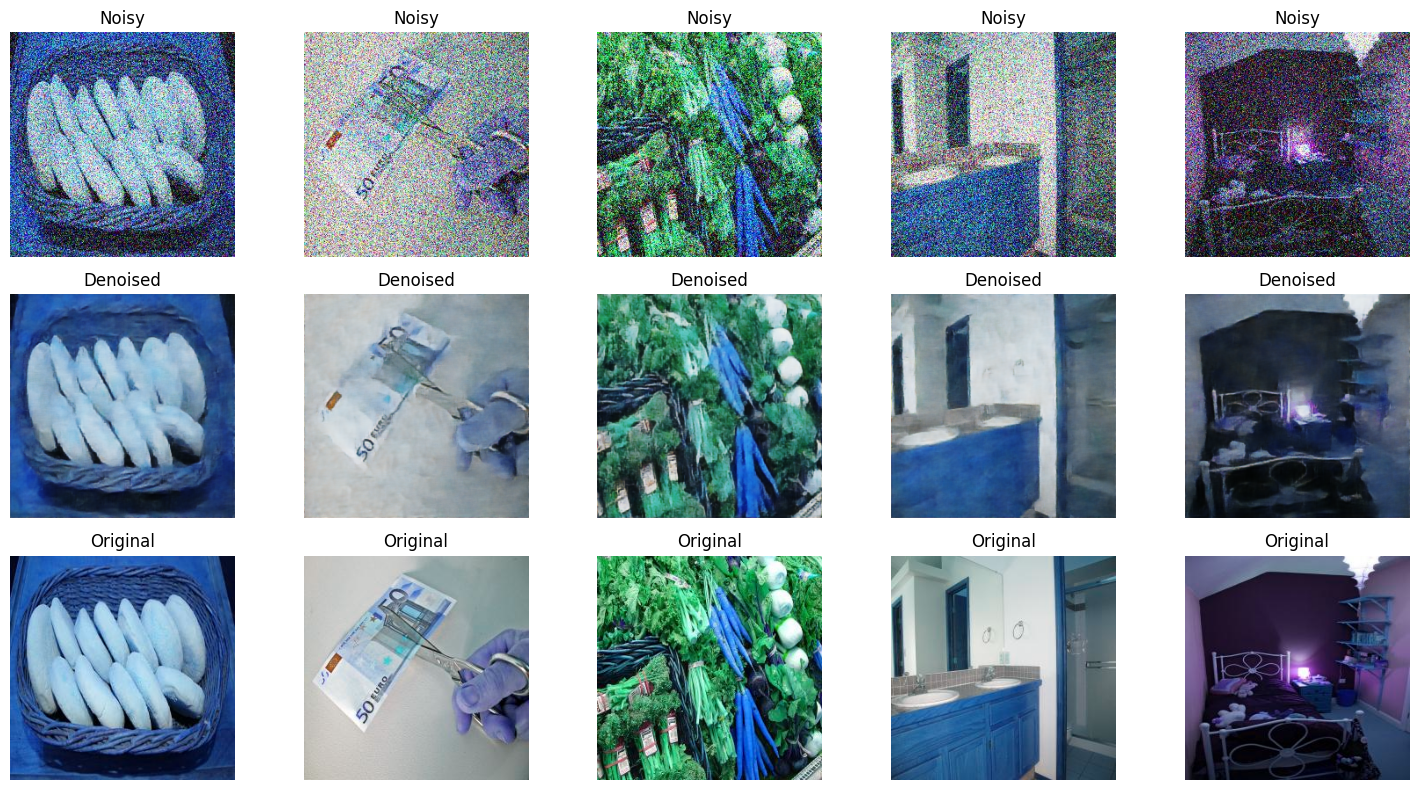

In [43]:
# %% [markdown]
# ## 8. Visualisation des Résultats
def plot_results(n=5):
    plt.figure(figsize=(15,8))
    predictions = model.predict(X_test[:n])
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(X_test[i])
        plt.title("Noisy")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+n)
        plt.imshow(predictions[i])
        plt.title("Denoised")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(y_test[i])
        plt.title("Original")
        plt.axis('off')
    
    # Add padding between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()

plot_results()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


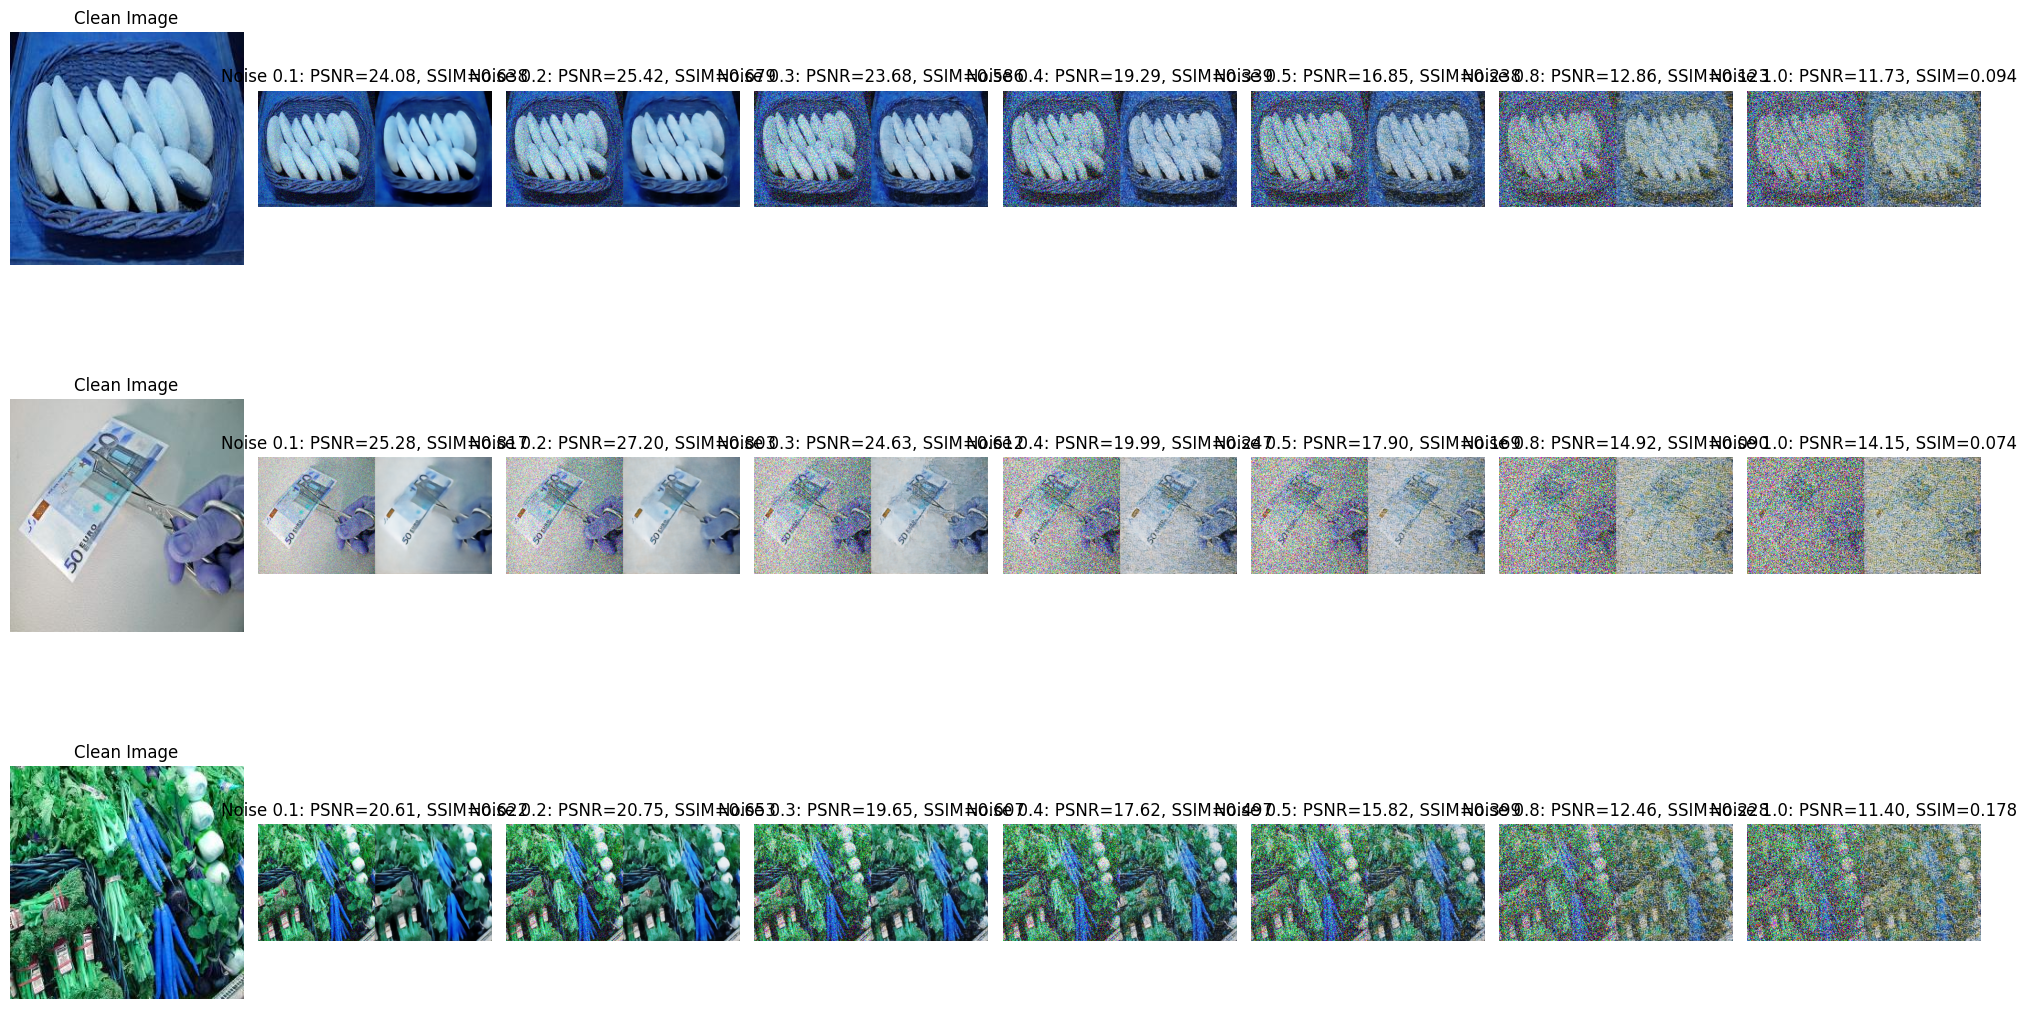

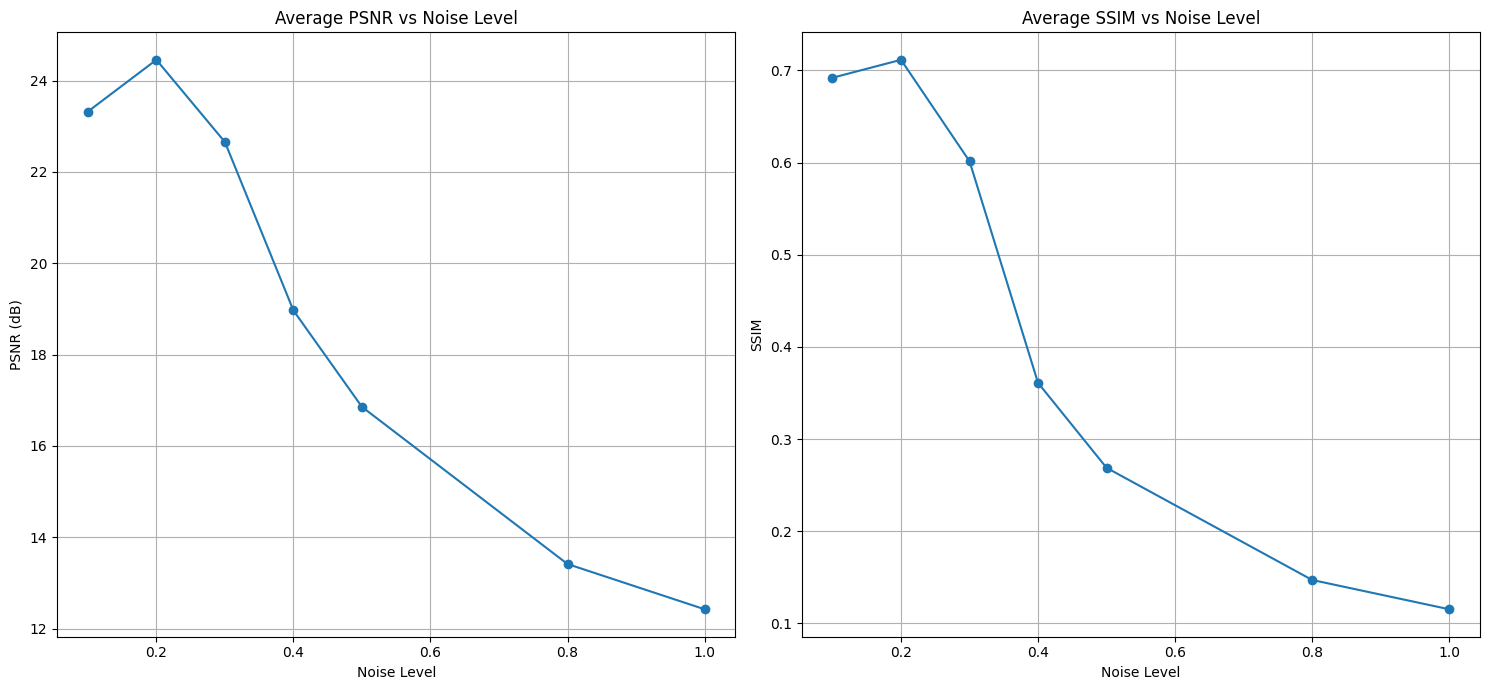

In [44]:
## Try to predict on clean image with deiffenrent noise level from 0.1 to 1
def add_gaussian_noise(image, noise_level):
    """
    Add Gaussian noise to an image
    
    Args:
        image: Clean image (normalized to [0,1])
        noise_level: Standard deviation of the noise
    
    Returns:
        Noisy image clipped to [0,1] range
    """
    noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip to valid range

# Select a few clean images from test set
num_samples = 3
selected_images = y_test[:num_samples]

# Define noise levels to test
noise_levels = [0.1,0.2,0.3,0.4,0.5,0.8,1.0]

# Create a figure for visualization
plt.figure(figsize=(20, 4*num_samples))

# Store metrics for each noise level
metrics = {level: {'psnr': [], 'ssim': []} for level in noise_levels}

for i, clean_img in enumerate(selected_images):
    # Show original clean image
    plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + 1)
    plt.imshow(clean_img)
    plt.title("Clean Image")
    plt.axis('off')
    
    # Process each noise level
    for j, noise_level in enumerate(noise_levels):
        # Create noisy image
        noisy_img = add_gaussian_noise(clean_img, noise_level)
        
        # Predict (denoise)
        denoised_img = model.predict(np.expand_dims(noisy_img, axis=0))[0]
        
        # Calculate metrics
        psnr_val = psnr(clean_img, denoised_img)
        ssim_val = ssim(clean_img, denoised_img, channel_axis=-1, win_size=5, data_range=1.0)
        metrics[noise_level]['psnr'].append(psnr_val)
        metrics[noise_level]['ssim'].append(ssim_val)
        
        # Display noisy and denoised
        plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + j + 2)
        
        # Create a side-by-side comparison
        comparison = np.hstack((noisy_img, denoised_img))
        plt.imshow(comparison)
        plt.title(f"Noise {noise_level}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate average metrics for each noise level
avg_metrics = {level: {'psnr': np.mean(values['psnr']), 
                       'ssim': np.mean(values['ssim'])} 
              for level, values in metrics.items()}

# Plot average metrics vs noise level
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, [avg_metrics[level]['psnr'] for level in noise_levels], 'o-')
plt.title('Average PSNR vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('PSNR (dB)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, [avg_metrics[level]['ssim'] for level in noise_levels], 'o-')
plt.title('Average SSIM vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()